In [1]:
import json

def save_file(fn):
    file = "data/pilot/"+fn+".json"
    for sensor in sdata:
        sdata[sensor].pop('lines', None)
    with open(file, 'w') as outfile:
        json.dump(sdata, outfile)
    print "File saved!", file

In [2]:
# STREAM DATA AND UPDATE PLOT

def stream():
    start_time = time()
    timepoints = []
    duration = 5*60 # total seconds to collect data

    clear_plot('A', sdata)
    clear_plot('M', sdata)
    clear_plot('G', sdata)
    PORT= 'COM6'#/dev/tty.VIBRATION-DevB
    
    BAUD= 9600

    # If you're not using Linux, you'll need to change this
    # check the Arduino IDE to see what serial port it's attached to
    print "RUNNING", ui_state["run"]
    try:
        ser = serial.Serial(PORT, BAUD)
        # flush any junk left in the serial buffer
        ser.flushInput()
        ser.reset_input_buffer()
        clean = lambda x: x.strip()
        # collect the data and plot a moving frame
        while ui_state["run"]:
            data = ser.readline().split(',')
            data = map(clean, data)

            flag = data[0]
            if flag == 'X': # Message
                print ", ".join(data)
                if data[1] == "Listening at 9600 baud.":
                    pass
                    ser.write(b'm\n')
                    ser.write(b'g\n')
                pass

            elif len(data) == 4:
                # sometimes the incoming data is garbage, so just 'try' to do this
                t = time()-start_time
                if t > duration: ui_state["run"]=False

                try:
                    data = map(lambda x: float(x)/1024, data[1:])
                    current_time = t

                    # update the plotted data
                    add_data(sdata, flag, data, t)

                    # slide the viewing frame along
                    if current_time > view_time:
                        plt.subplot(sdata[flag]['plt'])
                        plt.xlim([current_time-view_time,current_time])
                    # when time's up, kill the collect+plot loop
                except: pass
                fig1.canvas.draw()
        ser.write('a')
        ser.close()
        record.value = "Record"

    except ValueError as err: 
        print "value error", err
    except serial.SerialException as err:
        print "serial error", err
    finally:
        if ser: 
            ser.close()
            record.value = "Record"

In [3]:
from ipywidgets import widgets
from IPython.display import display

ui_state = {
    'run': False
}

def generate_ui():
    # UI
    record = widgets.Button(description="Record")
    button = widgets.Button(description="Save File")
    text = widgets.Text(description="Session", width=300)
    display(record)
    display(text)
    display(button)

    # HANDLERS
    def handle_record(sender):
        if sender.description == "Record":
            sender.description = "Stop"
            ui_state['run'] = True
            stream()
        else:
            sender.description = "Record"
            ui_state['run'] = False
    def handle_submit(sender):
        pass
    def on_button_click(b):
        save_file(text.value)

    text.on_submit(handle_submit)
    button.on_click(on_button_click)
    record.on_click(handle_record)
    return record, button, text


<IPython.core.display.Javascript object>


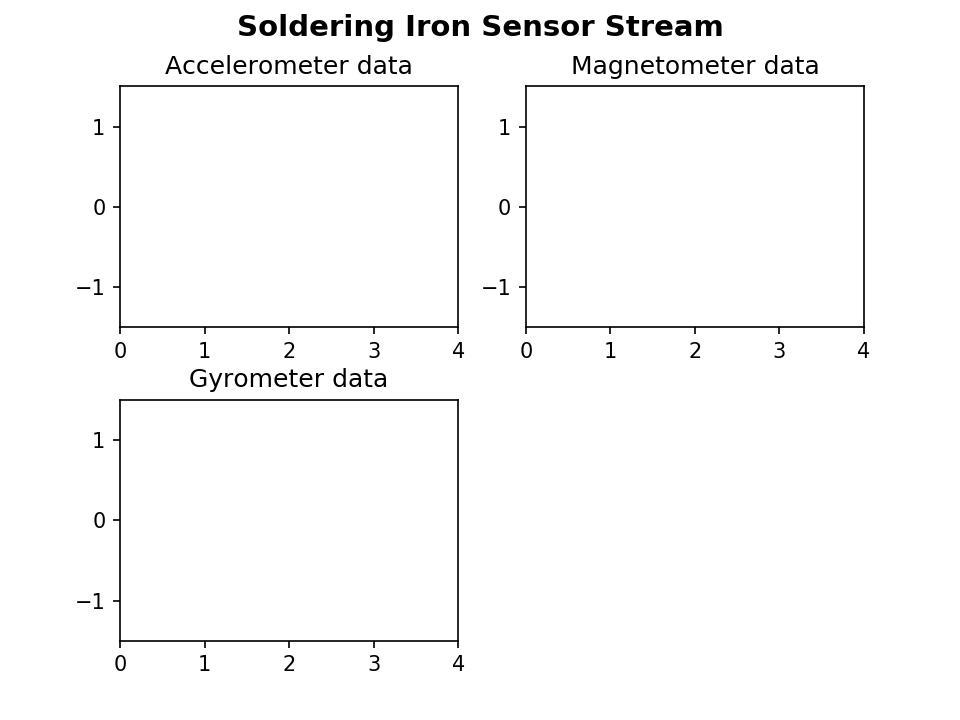

c:\python27\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Button(description=u'Record', style=ButtonStyle())

Text(value=u'', description=u'Session')

Button(description=u'Save File', style=ButtonStyle())

In [4]:
%matplotlib notebook

# run this in a Jupyter (IPython) Notebook!
# modified from http://www.lebsanft.org/?p=48
# http://pyserial.readthedocs.org/en/latest/pyserial_api.html
import serial, random
import numpy as np
from matplotlib import pyplot as plt
from time import time, sleep

## PREPARE PLOT FOR ANIMATION
plt.ion() 

def add_line(sdata, flag):
    marks = ['r', 'g', 'b']
    for i in range(3):
        line, = plt.plot(sdata[flag]["data"][i], marks[i])
        sdata[flag]["lines"].append(line)
def add_data(sdata, flag, data, time):
    sdata[flag]['time'].append(time)
    for i in range(3):
        sdata[flag]['lines'][i].set_xdata(sdata[flag]['time'])
        sdata[flag]['data'][i].append(data[i])
        sdata[flag]['lines'][i].set_ydata(sdata[flag]['data'][i])
def clear_plot(flag, sdata):
    sdata[flag]['time']= []
    sdata[flag]['data']=([],[],[])

def make_plot(flag, sdata, subplot, title):
    sdata[flag] = {
        'data': ([],[],[]),
        'lines':[],
        'time': []
    }
    splt = plt.subplot(subplot)
    splt.set_title(title)
    add_line(sdata, flag)
    plt.ylim(yrange)
    plt.xlim([0,view_time])
    sdata[flag]['plt'] = subplot

sdata = {}
yrange = [-1.5,1.5]
view_time = 4 # seconds of data to view at once


fig1 = plt.figure()
# http://matplotlib.org/users/text_props.html
fig1.suptitle('Soldering Iron Sensor Stream', fontsize='14', fontweight='bold')
plt.xlabel('time(s)', fontsize='14', fontstyle='italic')
plt.ylabel('magnitude', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

make_plot('A', sdata, 221, "Accelerometer data")
make_plot('M', sdata, 222, "Magnetometer data")
make_plot('G', sdata, 223, "Gyrometer data")

fig1.subplots_adjust(hspace=0.3)
record, button, text = generate_ui()
#